In [1]:
from pyNA.pyna import pyna
import openmdao.api as om
import numpy as np

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/laurensvoet/miniconda3/lib/python3.10/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)
/var/folders/6w/2tdqp9m179gg5blnzww9hgjc0000gn/T/ipykernel_24186/443738326.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


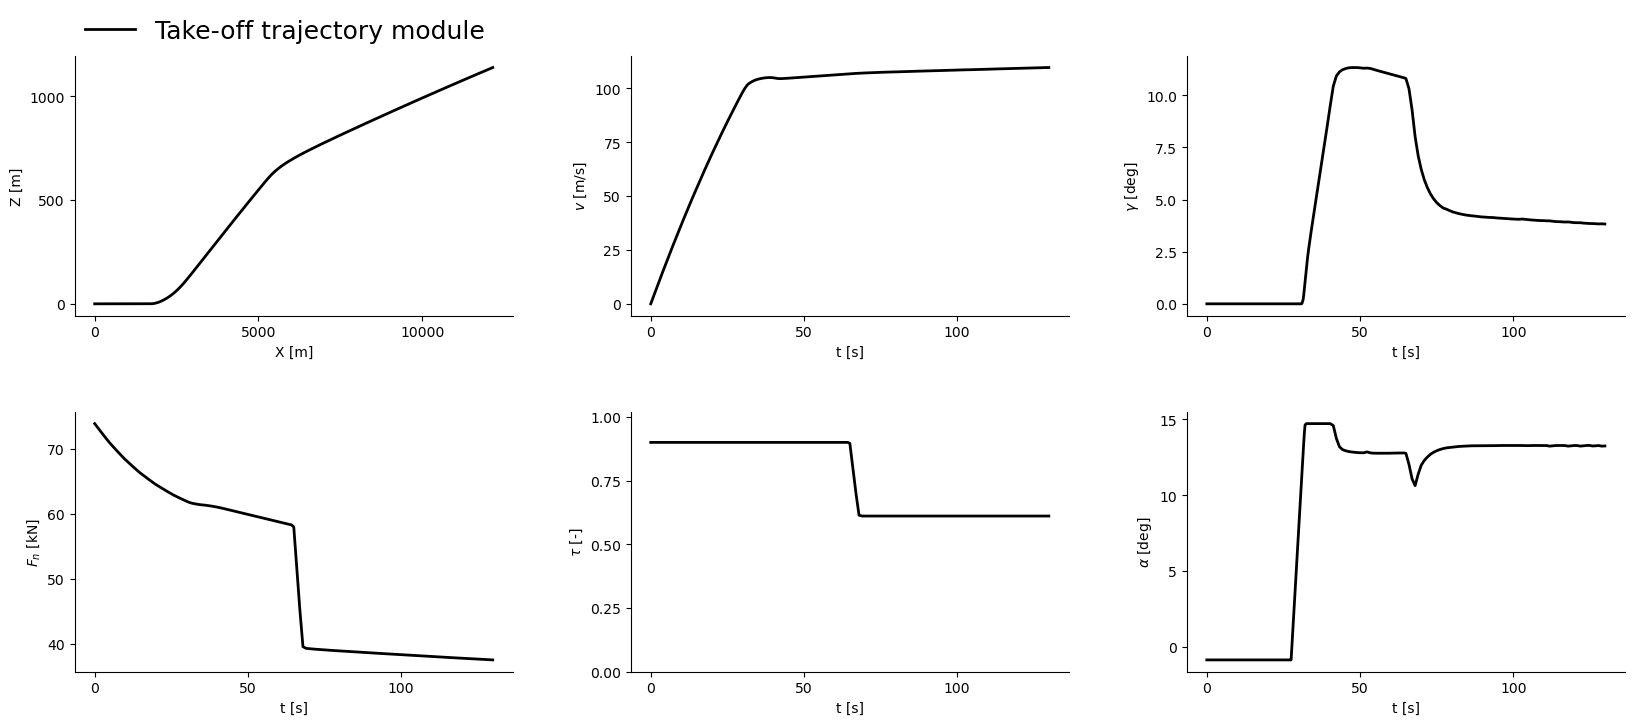

In [2]:
# Get NASA STCA trajectory from file
py_stca = pyna()
py_stca.trajectory.solve(py_stca.settings)
py_stca.plot_trajectory()

In [3]:
# Compute NASA STCA trajectory using take-off model
z_cb = py_stca.trajectory.path.get_val('z')[np.where(py_stca.trajectory.path.get_val('tau') < 0.65)[0][0]]
v_max = py_stca.trajectory.path.get_val('v')[-1]
x_max = py_stca.trajectory.path.get_val('x')[-1]

py = pyna(case_name='stca',
          trajectory_mode='model',
          z_cb=z_cb,
          v_max=v_max,
          x_max=x_max,
          pkrot=True)

# Trajectory controls
tau={'groundroll':0.88, 'rotation':0.88, 'liftoff':0.88, 'vnrs':0.88, 'cutback':0.61}
theta_flaps={'groundroll':10., 'rotation':10., 'liftoff':10., 'vnrs':10., 'cutback':10.}
theta_slats={'groundroll':-6., 'rotation':-6., 'liftoff':-6., 'vnrs':-6., 'cutback':-6.}

py.trajectory.solve(py.settings, py.aircraft, tau=tau, theta_flaps=theta_flaps, theta_slats=theta_slats)


--- Constraint Report [phases] ---
    --- groundroll ---
        [final]   0.0000e+00 == flight_dynamics.v_rot_residual [m/s]
    --- rotation ---
        [final]   1.1000e+00 == flight_dynamics.n [None]
    --- liftoff ---
        [path]    0.0000e+00 <= flight_dynamics.gamma_dot  [deg/s]
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]
    --- vnrs ---
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]
        [path]    0.0000e+00 <= gamma  [deg]
    --- cutback ---
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]



/Users/laurensvoet/miniconda3/lib/python3.10/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 4.160580 seconds.
Total jacobian shape: (247, 169) 


Jacobian shape: (247, 169)  ( 3.91% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 169  (93.5% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 4.160580 sec.
Time to compute coloring: 0.202401 sec.
Memory to compute coloring: 0.285156 MB.

List of user-set options:

                                    Name   Value                used
                acceptable_compl_inf_tol = 0.1                   yes
              acceptable_constr_viol_tol = 0.1                   yes
                         acceptable_iter = 0                     yes
               acceptable_obj_change_tol = 0.1                   yes
                          acceptable_tol = 0.01                  yes
                  bound_mult_init_method = m

Converged: True


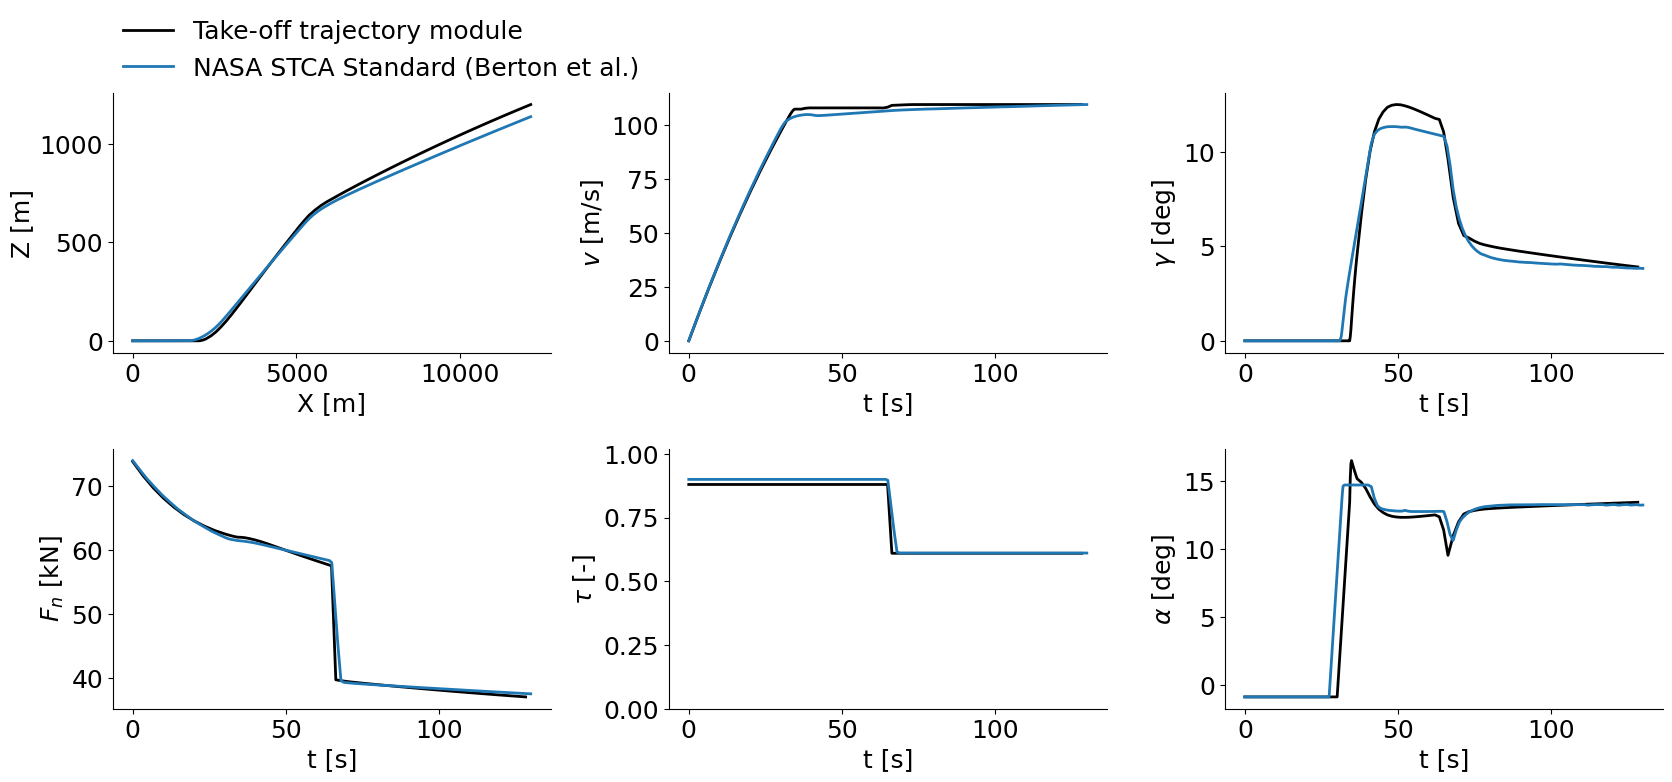

In [6]:
py.plot_trajectory(paths_compare=[py_stca.trajectory.path], labels_compare=['NASA STCA Standard (Berton et al.)'])

In [5]:
# Compute error between the trajectories
t_end_min = np.min((py.trajectory.path.get_val('t_s')[-1], py_stca.trajectory.path.get_val('t_s')[-1]))

n = np.size(py_stca.trajectory.path.get_val('t_s'))
t_ip = np.linspace(0, t_end_min, n)

for i,var in enumerate(['x', 'z', 'v', 'gamma', 'F_n', 'tau', 'alpha']):

    x_ip = np.interp(t_ip, py.trajectory.path.get_val('t_s'), py.trajectory.path.get_val(var)) / np.max(py_stca.trajectory.path.get_val(var))
    x_ip_stca = np.interp(t_ip, py_stca.trajectory.path.get_val('t_s'), py_stca.trajectory.path.get_val(var)) / np.max(py_stca.trajectory.path.get_val(var))
    
    mre = sum(abs(x_ip-x_ip_stca))/n

    self.assertLessEqual(mre, 0.05)

NameError: name 'self' is not defined

In [ ]:
np.sum(abs(x_ip_stca-x_ip))/np.size(x_ip_stca)